# Explorar acesso ao kafka

In [9]:
!pip install --quiet azure-storage-blob delta

In [10]:
import sys
import requests
import time
import os
import pyspark
import seaborn as sns
import matplotlib.pyplot as plt
import socket

from azure.storage.blob import BlobClient
from delta import *
from os import path
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StringType, DateType, StructType, StructField
from pyspark.sql.avro.functions import *

In [11]:
spark = (SparkSession.builder
    .appName("ExploreKafka")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")         
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

In [12]:
bootstrap = "nemesys-stream-101-kafka-external-bootstrap.nemesys-stream-101.svc:9094"
offset = "earliest"
topico = "stocks.StockData.stocks"
SCHEMA_REGISTRY = "http://nemesys-sr-schema-registry-headless.nemesys-stream-101.svc:8081"

In [13]:
# retrieve the latest schema
url = '{}/subjects/{}-value/versions/latest/schema'.format(SCHEMA_REGISTRY, topico)
# print(url)
response = requests.get(url)
# error check
response.raise_for_status()
# extract the schema from the response
schema = response.text

In [14]:
# (spark
#     .readStream
#     .format("kafka")
#     .option("kafka.bootstrap.servers", bootstrap)
#     .option("subscribe", topico)
#     .option("startingOffsets", offset)
#     .option("security.protocol", "SSL")
#     .load()
#     .selectExpr("substring(value, 6) as avro_value")
#     .select(from_avro(col("avro_value"), schema).alias("value"))
#     .select("value.*")
#     .writeStream
#     .format('delta')
#     .outputMode('append')
#     .option('mergeSchema', 'true')
#     .option('checkpointLocation', "lakehouse/checkpoint/stocks")
#     .trigger(once=True)
#     .start("lakehouse/stocks")
#     .awaitTermination()
# )
    

In [15]:
# df = (
#     spark
#     .read
#     .format("delta")
#     .load("lakehouse/stocks")
# )

In [16]:
df2 = (spark
    .read
    .format("kafka")
    .option("kafka.bootstrap.servers", bootstrap)
    .option("subscribe", topico)
    .option("startingOffsets", offset)
    .option("security.protocol", "SSL")
    .load()
    .selectExpr("substring(value, 6) as avro_value")
    .select(from_avro(col("avro_value"), schema).alias("value"))
    .select("value.*")       
)
df2.createOrReplaceTempView("stocks")

In [17]:
%%time

df = %sql \
    select \
        ticker, \
        description, \
        timestamp, \
        open, \
        high, \
        low, \
        close, \
        volume \
    from stocks \
    where ticker in ("AAPL") \
      and timestamp >= current_timestamp - interval 24 hours \
    order by ticker, timestamp

CPU times: user 3.58 ms, sys: 0 ns, total: 3.58 ms
Wall time: 27.3 ms


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


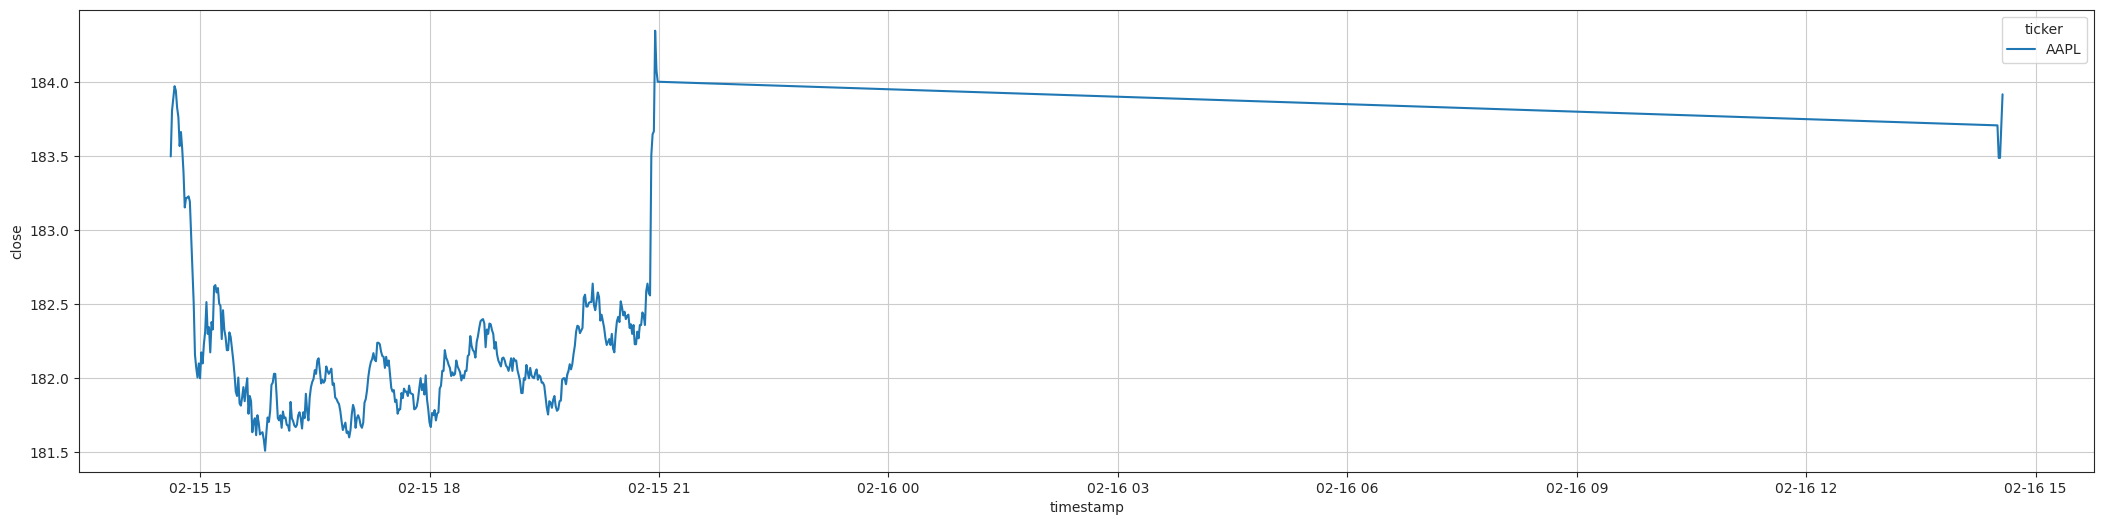

In [18]:
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(26,6))

sns.set_style("ticks",{'axes.grid' : True})

ax = sns.lineplot(df.toPandas(), x="timestamp", y="close", hue="ticker")
